In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pylab 
from collections import Counter
from clickhouse_driver import Client
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
from plotly.subplots import make_subplots
import plotly.express as px
from array import array
import math

In [2]:
data = pd.read_csv('insurance (1).csv')

In [3]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


![stats](https://miro.medium.com/max/1200/1*SaKp9J6hxzn6h1G-GJ71LQ.jpeg)

**Когда применяем статистику в своей работе?**
* Дескриптивная статистика (описание данных с помощью конкретных числовых характеристик, часто в сопровождении графических и табличных визуализаций);
* Проверка статистических гипотез (критерии проверки значимости, критерии согласия);
* Анализ зависимостей (корреляционный, факторный анализ)

# Числовые характеристики выборки

Позволяют охарактеризовать набор значений единым числом, которое может характеризовать ситуацию в среднем, наиболее типичную ситуацию и так далее.

## Простое среднее арифметическое

**Генеральная совокупность** - совокупность всех объектов, относительно которых предполагается делать выводы при изучении конкретной задачи.
**Выборка** - часть генеральной совокупности элементов, которая охватывается экспериментом.


Важно, если мы работаем, например, с клиентами приложения, то генеральная совокупность - все наши клиенты, а не все люди мира))
Но зависит от нашей цели, если мы внесли изменения в интерфейс экрана оформления заказа и тестируем его на выборках (группах) из 10% наших клиентов, то генеральная совокупность - все наши клиенты и мы по результатам эксперимента на наших группах оцениваем влияние изменения на всех клиентов приложения. А вот если мы хотим оценить, например, сколько в среднем денег на такси тратят все клиенты с разными ОС приложения, использующую такси во всем мире, а у нас есть только данные по клиентам приложения Ситимобил, то генеральная совокупность - все люди, использующие такси, а выборка - все наши клиенты.

**Расчет среднего арифметического для генеральной совокупности**

Отлично знакомая всем с детства формула, сумму всех элементов мы делим на количество элементов и вуаля)

![mean](https://completerepair.ru/images/6/6371/kak-nahodit-srednee-arifmeticheskoe.jpg)

где:
* x - значения элементов;
* n - количество элементов

Рассчитаем средний возраст всех пациентов в имеющемся у нас наборе данных. В данном случае, предполагаем, что это все наши пациенты и поэтому мы располагаем генеральной совокупностью, а не выборкой.

<AxesSubplot:xlabel='age', ylabel='Count'>

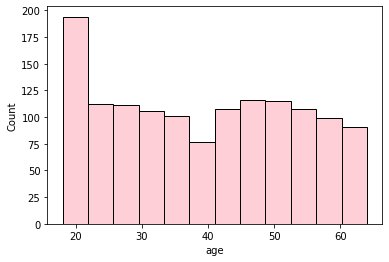

In [4]:
sns.histplot(data['age'],color = 'pink')

In [5]:
def average_age(data):
    return round(sum(data)/len(data),0)

In [6]:
print(average_age(data['age']))

39.0


Ну в целом среднее можем рассчитать с помощью большого количества библиотек

In [7]:
round(np.mean(data['age']),0)

39.0

In [8]:
data['age'].mean().round(0)

39.0

## Среднее арифметическое взвешенное

Многими забытое, но весьма полезное среднее арифметическое взвешенное значение. Когда используем? 

Среднее взвешенное — это величина, вычисляемая на основе чисел, «ценность» или «вес» которых не равнозначны. Например, если бы я хотела вычислить ваш средний итоговый балл по результатам курса, то возможно было бы не логично просто считать среднее по вашим суммарным баллам, так как итоговые проекты возможно более значимые, особенно часть со статистикой, так как за нее и дается больше всего баллов. И если кто-то не сдавал или плохо сдавал все задания, а последние (с самым большим количеством баллов) сдал, то на обычное среднее это очень сильно повлияет. В таком случае, среднее взвешенное решило бы мою проблему.

Рассмотрим на нашем примере, например, мы хотим получить среднюю сумму оплат клиентов. Но как было сказано коллегами на семинаре и как мы можем видеть, с увеличением возраста растут и суммы оплат, поэтому попробуем отрегулировать это с помощью среднего взвешенного, более возрастной группе — самый маленький вес. P.S - на практике так делать с деньгами не стоит, тут просто наглядный пример на не рандомных данных, но бывают случаи когда это нужно)

По квантилям отберем самых возрастных клиентов

In [9]:
data['age'].quantile([0.20,0.50,0.85,.95])

0.20    24.0
0.50    39.0
0.85    56.0
0.95    62.0
Name: age, dtype: float64

Упакуем всех по группам

In [10]:
data['wheight'] = np.where(data['age'] < 25,0.3,np.where(data['age'] < 40,0.3,np.where(data['age'] < 57,0.3,0.1)))

In [11]:
data.head()

,age,sex,bmi,children,smoker,region,charges,wheight
0,19,female,27.900,0,yes,southwest,16884.92400,0.3
1,18,male,33.770,1,no,southeast,1725.55230,0.3
2,28,male,33.000,3,no,southeast,4449.46200,0.3
3,33,male,22.705,0,no,northwest,21984.47061,0.3
4,32,male,28.880,0,no,northwest,3866.85520,0.3


**Как считать среднее взвешенное**

![wa](https://wikimedia.org/api/rest_v1/media/math/render/svg/69a1b3dcb3eaa3b4e7cf5576b364763df7c10e28)

где:
* w - веса, которые мы задали;
* x - наши значения

In [12]:
def wheight_average(data,wheight):
    return sum(data * wheight)/sum(wheight)

In [13]:
wheight_average(data['charges'],data['wheight'])

12638.671565040175

С этим же отлично справляется numpy:

In [14]:
np.average(data['charges'], weights=data['wheight'])

12638.671565040451

## Скользящее среднее

**Скользящее среднее** - общее название для семейства функций, значения которых в каждой точке определения равны среднему значению исходной функции за предыдущий период. Скользящие средние обычно используются с данными временных рядов для сглаживания краткосрочных колебаний и выделения основных тенденций или циклов, в целом ничего не мешает нам использовать его для отслеживания чего-либо во временной динамике, чтобы видеть реальные скачки и аномалии.

Типы скользящего среднего:

### Простое скользящее среднее (SMA)

**Простое скользящее среднее** - арифметическое скользящее среднее (англ. simple moving average, англ. SMA) численно равно среднему арифметическому значений исходной функции за установленный период

![SMA](https://wikimedia.org/api/rest_v1/media/math/render/svg/e2bf09dc6deaf86b3607040585fac6078f9c7c89)

где:
* n - количество периодов (например, 3 дня, 10 часов и так далее, любой период, который нам нужен);
* p - значения в заданный период времени

То есть мы создаем некоторое временное окно, за которое вычисляем среднее значение, таким образом сглаживая нашу кривую, но если в данных имеется серьезная аномалия, то мы все равно это заметим.

К сожалению, в нашем наборе данных нет данных с датами, так что используем другой набор данных. С данными по поездкам на такси по дням.

In [15]:
df = pd.read_csv('rides_data.csv')

In [16]:
df.head()

,date,rides
0,2015-12-06,3539
1,2015-12-07,3703
2,2015-12-08,4817
3,2015-12-09,3796
4,2015-12-10,3676


Для начала посмотрим, как вообще ведет себя динамика количества поездок

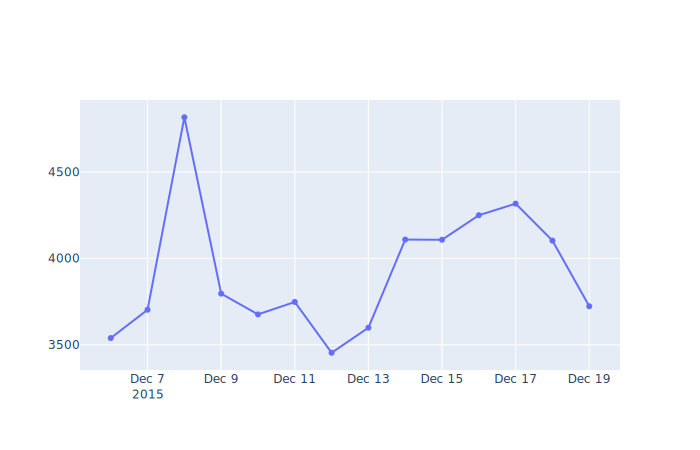

In [17]:
fig = go.Figure(data=go.Scatter(x=df['date'], y=df['rides']))
fig.show('svg')

Посчитаем скользящее среднее для окна в 3 дня

In [18]:
def moving_average(data, n):
    sum = 0
    result = list(0 for x in data)

    for i in range(0, n):
        sum = sum + data[i]
        result[i] = sum / (i + 1)

    for i in range(n, len(data)):
        sum = sum - data[i - n] + data[i]
        result[i] = sum / n

    return result

In [19]:
df['sma'] = moving_average(df['rides'],3)

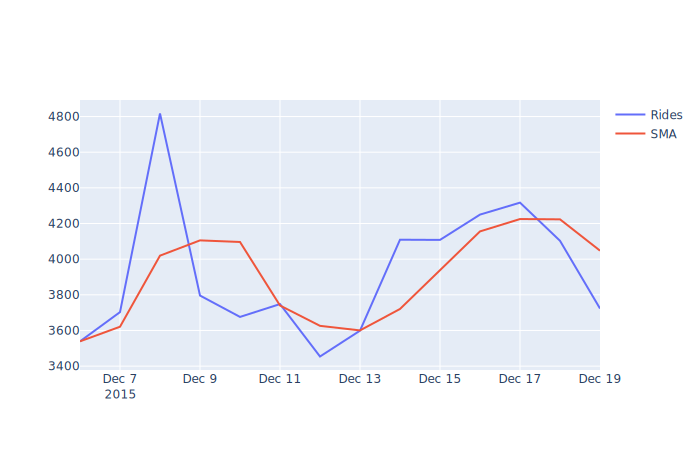

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y= df.rides,
                    mode='lines',
                    name='Rides'))
fig.add_trace(go.Scatter(x=df['date'], y=df.sma,
                    mode='lines',
                    name='SMA'))

fig.show('svg')

Мы конечно молодцы, но pandas это тоже умеет :D 

In [21]:
rolling = df['rides'].rolling(window=5)
df['sma_pandas'] = rolling.mean()

In [22]:
df.head(10)

,date,rides,sma,sma_pandas
0,2015-12-06,3539,3539.000000,NaN
1,2015-12-07,3703,3621.000000,NaN
2,2015-12-08,4817,4019.666667,NaN
3,2015-12-09,3796,4105.333333,NaN
4,2015-12-10,3676,4096.333333,3906.2
5,2015-12-11,3748,3740.000000,3948.0
6,2015-12-12,3454,3626.000000,3898.2
7,2015-12-13,3599,3600.333333,3654.6
8,2015-12-14,4109,3720.666667,3717.2
9,2015-12-15,4108,3938.666667,3803.6


**Плюсы**
* простота реализации и интерпретации;
* сглаживание дает возможность отметить и правда значимые аномалии


**Минусы**
* одинаковые веса. В предыдущий день и в дату 2 дня назад вес для нас один (так как мы просто считаем среднее между ними), но это не есть правда, так как более близкие дни, например, могут быть более близки и по значениям. Эту проблему решает следующий способ расчета.

### Взвешенное скользящее среднее (WMA)

**Взвешенное скользящее среднее** - скользящее среднее, при вычислении которого вес каждого члена исходной функции, начиная с меньшего, равен соответствующему члену арифметической прогрессии. То есть, при вычислении WMA для временного ряда, мы считаем последние значения исходной функции более значимы чем предыдущие, причём функция значимости линейно убывающая.

По сравнению с простым скользящим средним, линейно-взвешенное скользящее среднее (или просто взвешенное скользящее среднее, WMA) придает больший вес самой последней цене и постепенно меньше, когда мы оглядываемся назад во времени. При средневзвешенном значении за 3 дня количество поездок 3-го дня будет умножено на 3, поездки 2-го дня — на 2 и так далее.

![wma](https://wikimedia.org/api/rest_v1/media/math/render/svg/36436c2ba490d24f9ec50df0befb7d83d8383944)

In [23]:
weights = np.array([0.5,0.4,0.3,0.2,0.1])
sum_weights = np.sum(weights)

df['WMA'] = (df['rides'].rolling(window=5).apply(
    lambda x: np.sum(weights * x) / np.sum(weights), raw=False))

In [24]:
df.head(7)

,date,rides,sma,sma_pandas,WMA
0,2015-12-06,3539,3539.000000,NaN,NaN
1,2015-12-07,3703,3621.000000,NaN,NaN
2,2015-12-08,4817,4019.666667,NaN,NaN
3,2015-12-09,3796,4105.333333,NaN,NaN
4,2015-12-10,3676,4096.333333,3906.2,3881.733333
5,2015-12-11,3748,3740.000000,3948.0,4018.066667
6,2015-12-12,3454,3626.000000,3898.2,4083.133333


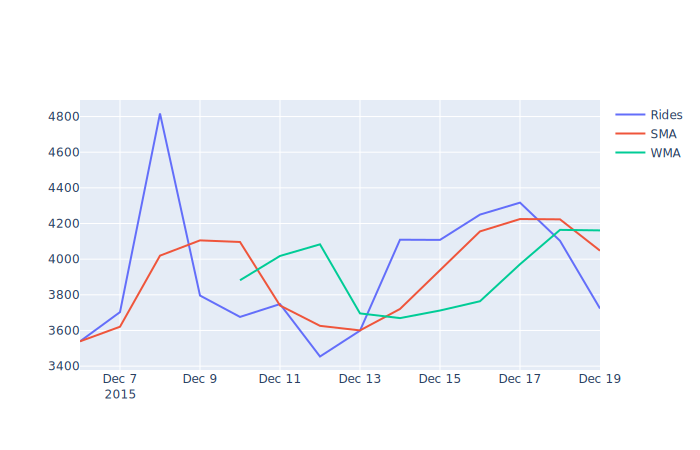

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y= df.rides,
                    mode='lines',
                    name='Rides'))
fig.add_trace(go.Scatter(x=df['date'], y=df.sma,
                    mode='lines',
                    name='SMA'))

fig.add_trace(go.Scatter(x=df['date'], y=df.WMA,
                    mode='lines',
                    name='WMA'))
fig.show('svg')

In [26]:
df.head()

,date,rides,sma,sma_pandas,WMA
0,2015-12-06,3539,3539.000000,NaN,NaN
1,2015-12-07,3703,3621.000000,NaN,NaN
2,2015-12-08,4817,4019.666667,NaN,NaN
3,2015-12-09,3796,4105.333333,NaN,NaN
4,2015-12-10,3676,4096.333333,3906.2,3881.733333


### Экспоненциальное взвешенное скользящее среднее (EWMA/EMA)

Мы обсудили, что зачастую последние данные - самые важные и мы хотим давать им наибольший вес при расчете среднего и у нас есть возможность регулировать это с помощью взвешенного скользящего среднего. Экспоненциальное скользящее среднее преследует ту же цель.

**Экспоненциальное скользящее среднее** - разновидность взвешенной скользящей средней, веса которой убывают экспоненциально и никогда не равны нулю.
Разница заключается в том, что учитываются значения за весь период наблюдения, а значимость (вес) уменьшается экспоненциально и никогда не равна нулю, то есть самым новым ценам придается больший вес. При этом используется не линейная арифметическая или другая прогрессия, а формула экспоненциального сглаживания, которая применяется при прогнозировании временных рядов.
Иначе говоря, для расчета экспоненциального скользящего среднего используется предыдущее значение цены, помноженное на коэффициент сглаживания, которое прибавляется к предыдущему значению цены. Таким образом, чем больше значение α, тем меньшее влияние оказывает предыдущий показатель на текущую величину EMA

![ema2](https://miro.medium.com/max/217/1*brKe2J9IJN89-6LkP-a3Uw.png)

где:
* EMAt – EMA в точке, соответствующей определенному моменту времени,
* EMAt-1 – EMA в точке, предыдущей заданному моменту времени,
* p – исходное значение элемента, соответствующее определенному моменту времени,
* α – коэффициент сглаживания (англ. smoothing constant)

Рассчитаем:)

In [27]:
def EMA(n, data):
    
    s = data[:n].sum()/n    
    m = 2/(n+1)                 
 
    out = np.zeros(len(data))
 
    for i in range(len(data)):
        if i == n-1:
            out[i] = s
        elif i > n-1:
            out[i] = ((data[i] - out[i-1]) * m) + out[i-1]
        elif i < n-1:
            out[i] = np.nan
 
    return list(out)

In [28]:
df['ema'] = EMA(3, df['rides'])

In [29]:
df.head(15)

,date,rides,sma,sma_pandas,WMA,ema
0,2015-12-06,3539,3539.000000,NaN,NaN,NaN
1,2015-12-07,3703,3621.000000,NaN,NaN,NaN
2,2015-12-08,4817,4019.666667,NaN,NaN,4019.666667
3,2015-12-09,3796,4105.333333,NaN,NaN,3907.833333
4,2015-12-10,3676,4096.333333,3906.2,3881.733333,3791.916667
5,2015-12-11,3748,3740.000000,3948.0,4018.066667,3769.958333
6,2015-12-12,3454,3626.000000,3898.2,4083.133333,3611.979167
7,2015-12-13,3599,3600.333333,3654.6,3695.666667,3605.489583
8,2015-12-14,4109,3720.666667,3717.2,3669.400000,3857.244792
9,2015-12-15,4108,3938.666667,3803.6,3711.933333,3982.622396


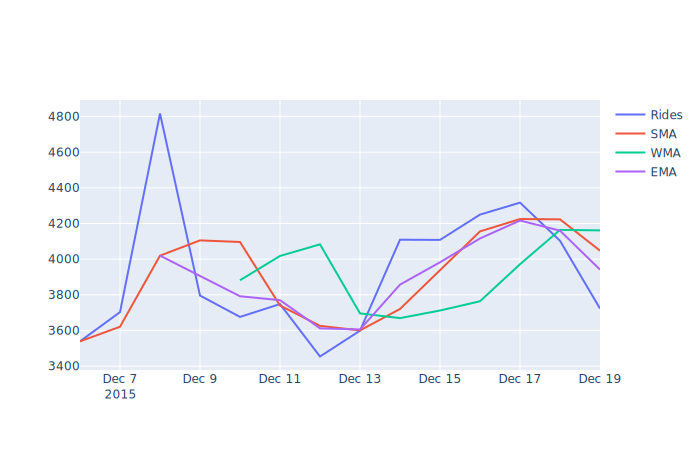

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y= df.rides,
                    mode='lines',
                    name='Rides'))
fig.add_trace(go.Scatter(x=df['date'], y=df.sma,
                    mode='lines',
                    name='SMA'))

fig.add_trace(go.Scatter(x=df['date'], y=df.WMA,
                    mode='lines',
                    name='WMA'))
fig.add_trace(go.Scatter(x=df['date'], y=df.ema,
                    mode='lines',
                    name='EMA'))
fig.show('svg')

Также просто реализуется с помощью метода ewm() в pandas. Дока и примеры - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

## Для генеральной совокупности и для выборки

**Среднее арифметическое для выборки**

 Среднее арифметическое для выборки считается по абсолютно такой же простой формуле, но в качестве n - количество элементов выступает количество элементов в нашей выборке. Но важно оценивать, насколько сильно мы отклоняемся от среднего в генеральной совокупности, когда считаем его по выборке.

В этом нам поможет, так называемая, стандартная ошибка среднего.

**Стандартная ошибка среднего** - оценивает точность, с которой выборочное среднее оценивает среднее генеральной совокупности.

Случайным образом выберем клиентов из нашего набора данных и рассчитаем среднее для них, затем оценим, насколько выборочное среднее было близко к среднему генеральной совокупности.

In [31]:
data_elements = data.sample(n=25)

In [32]:
data_elements['age'].mean().round(0)

41.0

**Как рассчитать стандартную ошибку среднего**

![std](https://konspekta.net/infopediasu/baza12/3132696344074.files/image003.png)

где:
* S - выборочное стандартное отклонение;
* n - размер выборки

Для понимания того, как считается стандартная ошибка среднего, надо вспомнить такие понятия как дисперсия и среднеквадратическое отклонение.

## Дисперсия

![varmem](https://0701.static.prezi.com/preview/v2/4bmp7ww5i5vjl5yres4inyfght6jc3sachvcdoaizecfr3dnitcq_3_0.png)

Дисперсия характеризует меру рассеяния (разброса) случайной величины. Дисперсия — среднее арифметическое квадратов отклонений переменной от ее среднего значения.
* Формула вычисления дисперсии для генеральной совокупности:

![var](https://konspekta.net/studopediaru/baza19/2295584594329.files/image046.png)

где:
* x - элемент;
* x с чертой — среднее;
* n - количество элементов

Формула для расчета дисперсии для выборки — выглядит также, но делим не на количество элементов, а на n-1 (количество элементов минус -1)

Рассчитаем дисперсию

In [33]:
def variance(data):
    mean = sum(data)/len(data)
    return round(sum((xi - mean) **2 for xi in data)/len(data),3)

In [34]:
variance(data['age'])

197.254

In [35]:
np.var(data['age'])

197.2538519888909

## Среднеквадратическое отклонение

Дисперсия отличный показатель, но из-за того что мы возводим в квадрат разность между средним значением и значениями элементов,
получаемое значение получается слишком большим для интерпретации.

Эта проблема решается расчетом стандартного отклонения.

![std](https://cdn.kastatic.org/googleusercontent/N8xzWFc6eo0XBHEXZjz1SwvLSnPezvhTRF1P17kdjUG_tnJivGKkyCxbwVe4MZ0-USOxIZBohgcjdi8e7Z4Hswcqfw)

Как мы видим, это просто корень из дисперсии. В случае, если мы работаем с выборкой, то говорим не среднеквадратическое, а стандартное отклонение. Чем больше это значение, тем менее точно описывает наш набор данных среднее значение, так как разброс значений вокруг него очень велик.

Расчет среднеквадратического отклонения

In [36]:
def sqo(data):
    return round(math.sqrt(variance(data)),3)   

In [37]:
sqo(data['age'])

14.045

In [38]:
np.std(data['age'])

14.044709038954522

## Расчет стандартной ошибки среднего

Еще раз вспомним формулу

![std](https://konspekta.net/infopediasu/baza12/3132696344074.files/image003.png)

Таким образом, стандартная ошибка среднего это стандартное отклонение, которое мы умеем считать, деленное на квадратный корень из числа элементов в выборке.

Повторим, выберем случайным образом несколько значений из выборки, рассчитаем среднее и оценим, насколько оно точно считается

In [39]:
sample = data.sample(n=25)

In [40]:
sample['age'].mean()

35.24

Видоизменим формулу дисперсии (так как работаем с выборкой). 

In [41]:
def variance(data):
    mean = sum(data)/len(data)
    return round(sum((xi - mean) **2 for xi in data)/(len(data) - 1),3)

In [42]:
def standart_error(data):
    return sqo(data)/math.sqrt(len(data))

In [43]:
standart_error(sample['age'])

2.681

В scipy есть функция для этого дела тоже) а если считаем дисперсию для генеральной совокупности, надо добавить (ddof = 0)

In [44]:
stats.sem(sample['age'])

2.6809699737221973

Стандартная ошибка позволяет определить
значение переменной в генеральной
совокупности на основе выборочных данных
Стандартная ошибка (умноженная на два)
формирует доверительный интервал, в рамках
которого находятся значения переменной в
генеральной совокупности (с вероятностью
95%)

## Мода

Мода — числовое значение, которое встречается в выборке наибольшее количество раз. Расчет моды может быть полезен, если вы хотите найти самый типичный в вашем наборе данных элемент по какому-либо признаку. Например, если вы захотите узнать самый типичный (часто встречающийся) рост у жителей какого-либо города, то мода отлично подойдет, независимо от распределения.

Несколько важных моментов:
* если все значения в выборке встречаются одинаково часто, то считается, что в выборе нет моды;
* если два или более соседних элемента встречаются одинаково часто, то мода считается как среднее арифметическое между двумя этими элементами;
* если два и более не соседних элемента встречаются одинаково часто, то все эти значения считаются модами и распределение считается бимодальным (две моды) или мультимодальным (несколько мод)

Пример ярко выраженного бимодального распределения из интернетика

![bimod](http://sixsigmaonline.ru/Articles/0000152.png)

In [45]:
data = pd.read_csv('insurance (1).csv')

Найдем самую типичную по количеству детей семью в нашем наборе данных)

In [46]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [47]:
def mode(data):
    nums = Counter(list(data))
    most_common = [k for k, v in dict(nums).items() if v == max(list(nums.values()))]
    ind = [i for i, e in enumerate(set(data)) if e in most_common]
    if len(most_common) == 1:
        mode_value = most_common
    elif len(most_common) == len(data):
        mode_value = 'no_mode'
    elif np.diff(ind) > 1:
        mode_value = most_common
    else:
        mode_value = sum(most_common) / len(most_common)
    return mode_value

In [48]:
print(mode(data['children']))

[0]


Пример, когда два не соседних числа встречаются одинаково часто. Округлим суммы оплат клиентов, убрав дробную часть и посмотри на самую встречающуюся сумму или суммы.

In [49]:
data['charges'].round(0).value_counts()

11658.0    3
1632.0     3
2138.0     2
10602.0    2
4134.0     2
          ..
1737.0     1
26392.0    1
1627.0     1
10977.0    1
4688.0     1
Name: charges, Length: 1294, dtype: int64

In [50]:
print(mode(data['charges'].round(0))) 

[1632.0, 11658.0]


In [51]:
print(mode([1,1,1,2,2,2,4,5,6,7,8])) #пример, когда два соседних числа встречаются одинаково часто

1.5


In [52]:
stats.mode(data['children'])

ModeResult(mode=array([0]), count=array([574]))

In [53]:
stats.mode(data['charges'].round(0))

ModeResult(mode=array([1632.]), count=array([3]))

In [54]:
stats.mode([1,1,1,1,2,2,2,4,5,6,7,8,8,8,8])

ModeResult(mode=array([1]), count=array([4]))

## А распределение то не нормальное...

Среднее значение как мера центральной тенденции, а также дисперсия и среднеквадратическое отклонение — отличные информативные показатели, но как мы все знаем, если наше распределение не нормальное и не близко к нему, то они могут дать нам ложную информацию

## Нормальное распределение

![normal](https://www.termist.com/bibliot/stud/ma_en_sl/52/417_5_05.png)

На рисунке представлены типичные формы нормального распределения для разных значений среднего и ско

Нормальное распределение зависит от 4-х параметров:

* математическое ожидание - "центр тяжести" распределения;
* дисперсия — степень разброса случайной величины относительно математического ожидания;
* коэффициент асимметрии — параметр формы распределения, определяющий его симметрию относительно математического ожидания;
* коэффициент эксцесса — параметр распределения, задающий "остроту" пика распределения.

**Важные характеристики нормального распределения**
* все меры центральной тенденции равны (среднее, медиана и мода);
* чем больше величина отклоняется от среднего, тем меньше будет частота его встречаемости;

Так как среднее значение очень хорошо характеризует совокупности, которые подчинены нормальному закону распределения, то и отклонения от среднего, очень хорошо характеризуют эту совокупность.

![nd](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Standard_deviation_diagram_%28decimal_comma%29.svg/325px-Standard_deviation_diagram_%28decimal_comma%29.svg.png)

## А как же характеризовать совокупности, распределенные не нормально?

Распределений много и с ними надо как-то работать)

![dist](https://habrastorage.org/getpro/habr/post_images/4f6/5f4/edb/4f65f4edb921715dbb56a320a65b101e.png)

## Медиана

Медиана — уровень показателя, который делит набор данных на две равные половины. Значения в одной половине меньше, а в другой больше медианы. В отличие от среднего арифметического, медиана — робастный показатель, то есть устойчивый к выбросам. Поэтому, если полагаясь на среднее, нам важно убедиться, что данные распределены нормально или близко к нормальному, то в случае с медианой — мы не сильно беспокоимся о распределении наших значений.

Возьмем для примера показатель поинтереснее, суммы оплат наших клиентов.

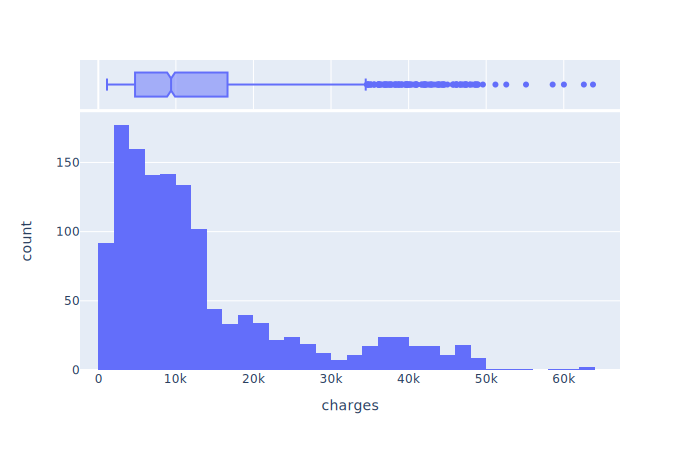

In [55]:
fig = px.histogram(data, x="charges",
                   marginal="box")
fig.show('svg')

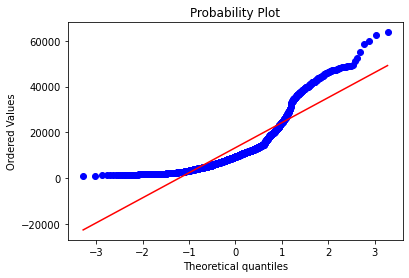

In [56]:
stats.probplot(data['charges'], dist="norm", plot=pylab)
pylab.show()

**Рассчитаем медиану**

In [57]:
def median(data):
    index = (len(data) - 1) // 2

    if (len(data) % 2):
        return sorted(data)[index]
    else:
        return (sorted(data)[index] + sorted(data)[index + 1])/2.0

In [58]:
median(data['charges'])

9382.033

In [59]:
data['charges'].median()

9382.033

## Размах вариации и межквартильный размах

### Размах

**Размах или разброс выборки** -разность между наибольшим и наименьшим значениями результатов наблюдений

In [60]:
def scope(data):
    return max(data) - min(data)

In [61]:
scope(data['charges'])

62648.554110000005

### Межквартильный размах 

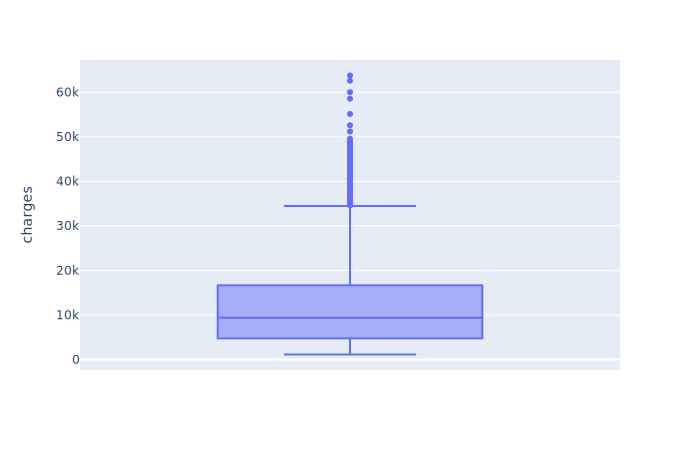

In [62]:
fig = px.box(data,y = data['charges'])
fig.show('svg')

В статистике для анализа выборки часто прибегают к другому показателю вариации – межквартильному размаху. Квартиль – это то значение, которые делит ранжированные (отсортированные) данные на части, кратные одной четверти, или 25%. Так, 1-й квартиль – это значение, ниже которого находится 25% совокупности. 2-й квартиль делит совокупность данных пополам (то бишь медиана), ну и 3-й квартиль отделяет 25% наибольших значений. Так вот межквартильный размах – это разница между 3-м и 1-м квартилями. У данного показателя есть одно неоспоримое преимущество: он является робастным, т.е. не зависит от аномальных отклонений.

**Межквартильный размах = Q3 - Q1**

In [63]:
def iq(data):
    Q1 = np.percentile(data,25,interpolation='midpoint')
    Q3 = np.percentile(data,75,interpolation='midpoint')
    return Q3-Q1

In [64]:
iq(data['charges'])

11879.80148

## Процентили

Сразу решим проблему с неверным неймингом))

**Процентиль** — мера, в которой процентное значение общих значений равно этой мере или меньше ее. Например, 90 % значений данных находятся ниже 90-го процентиля, а 10 % значений данных находятся ниже 10-го процентиля.

**Квартили** — значения, которые делят таблицу данных (или ее часть) на четыре группы, содержащие приблизительно равное количество наблюдений. Общий объем делится на четыре равные части: 25%, 50%, 75% 100%.

**Квантили** - значение, которое заданная случайная величина не превышает с фиксированной вероятностью.

Процентили позволяют получить много информации о данных, независимо от того, как они распределены:
* по положению медианы относительно 25го и 75го процентиля мы можем судить о том, насколько симметрично распределение

Вернемся к оплатам наших клиентов, построив box plot и посмотрев на значение процентилей или квартилей, мы можем сказать о том, что распределение сумм оплат сдвинуто в сторону небольших сумм и гораздо меньше высоких значений и разброс среди них гораздо выше, то есть наше распределение ассиметрично. Это мы можем увидеть и по графикам, но не всегда есть возможность их отсмотреть, например, если у нас настроены какие-то алерты на изменение процентилей и так далее)

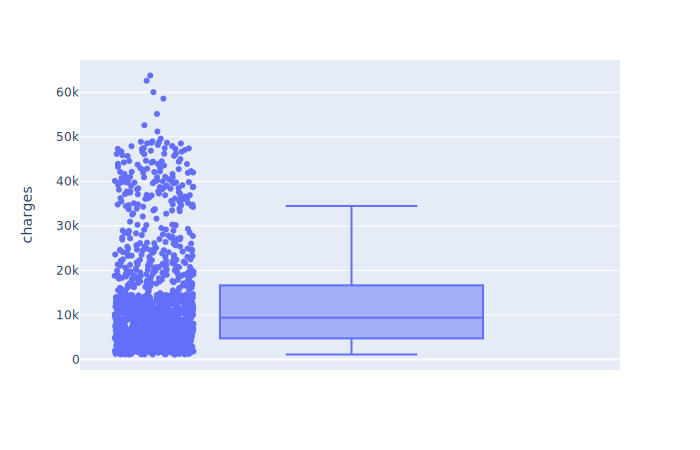

In [65]:
fig = px.box(data,y = data['charges'],points = 'all')
fig.show('svg')

![love](http://memesmix.net/media/created/ems58s.jpg)